In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import tensorflow.compat.v1 as tf
import random
import matplotlib.pyplot as plt

from sksurv.metrics import concordance_index_ipcw

from utils.utils import f_get_minibatch

from models.survite import SurvITE

import time

from sklearn.model_selection import train_test_split

import os

In [2]:
print(os.getcwd())

c:\Users\junio\OneDrive\바탕 화면\SurvivalAnalysis\SurvITE\survITE


In [3]:
ipm_type      = 'wasserstein'

weight        = False
is_smoothing  = False
is_treat      = True

is_training   = True#True

OUT_ITERATION = 5
N_tr = 5000
N_te = 5000

if not weight:
    weight_type = 'noweight'
else:
    weight_type  = '' 


if ipm_type == 'no_ipm':
    beta       = 0.
else:
    beta   = 1e-3 #1e-3

    
if is_smoothing:
    gamma  = 1e-3
else:
    gamma  = 0.


lr_rate   = 1e-3
mb_size   = 512

keep_prob = 0.7

seed           = 1234

TMAX           = 30
eval_times     = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]


# results_mse_hzrd1 = np.zeros([OUT_ITERATION, TMAX+1])
# results_mse_hzrd0 = np.zeros([OUT_ITERATION, TMAX+1])

# results_mse_surv1 = np.zeros([OUT_ITERATION, TMAX+1])
# results_mse_surv0 = np.zeros([OUT_ITERATION, TMAX+1])

# results_hte_hzrd   = np.zeros([OUT_ITERATION, TMAX+1])
# results_hte_surv   = np.zeros([OUT_ITERATION, TMAX+1])

# results1 = np.zeros([OUT_ITERATION, len(eval_times)])
# results2 = np.zeros([OUT_ITERATION, len(eval_times)])
# results3 = np.zeros([OUT_ITERATION, len(eval_times)])

In [4]:
seed         = 1234
modelname    = 'SurvITE'

# IMPORT OBSERVATIONAL DATASET

In [5]:
npz  = np.load('./data/tr_data.npz')
tr_x = npz['x']
tr_a = npz['a']
tr_t = npz['t']
tr_y = npz['y']

npz  = np.load('./data/te_data.npz')
te_x = npz['x']
te_a = npz['a']
te_t = npz['t']
te_y = npz['y']

tr_y_structured = [(tr_y[i], tr_t[i]) for i in range(len(tr_y))]
tr_y_structured = np.array(tr_y_structured, dtype=[('status', 'bool'),('time','<f8')])

te_y_structured = [(te_y[i], te_t[i]) for i in range(len(te_y))]
te_y_structured = np.array(te_y_structured, dtype=[('status', 'bool'),('time','<f8')])


TMAX           = 30
eval_times     = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]


results_mse_hzrd1 = np.zeros([1, TMAX+1])
results_mse_hzrd0 = np.zeros([1, TMAX+1])

results_mse_surv1 = np.zeros([1, TMAX+1])
results_mse_surv0 = np.zeros([1, TMAX+1])

results_hte_hzrd   = np.zeros([1, TMAX+1])
results_hte_surv   = np.zeros([1, TMAX+1])

results1 = np.zeros([1, len(eval_times)])
results2 = np.zeros([1, len(eval_times)])
results3 = np.zeros([1, len(eval_times)])

# TRAINING

In [6]:
num_Event   = 1

z_dim       = 100
x_dim       = np.shape(tr_x)[1]

num_layers1  = 3
h_dim1       = 100

num_layers2  = 2
h_dim2       = 100


input_dims = {
    'x_dim': x_dim,
    'num_Event': num_Event,
    't_max': TMAX+1
}
network_settings = {
    'z_dim': z_dim,     

    # Phi()
    'h_dim1': h_dim1, 
    'num_layers1': num_layers1, 

    # Hypothesis()
    'h_dim2': h_dim2, 
    'num_layers2': num_layers2,

    'active_fn': tf.nn.elu,
    'reg_scale': 0.,
    'ipm_term' : ipm_type, 
    'is_treat' : is_treat,
    'is_smoothing': is_smoothing
}


tf.reset_default_graph()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

model = SurvITE(sess, 'SurvITE', input_dims, network_settings)
sess.run(tf.global_variables_initializer())

saver       = tf.train.Saver()

savepath = '/{}/surviTE/'.format(modelname)

if not os.path.exists(savepath):
    os.makedirs(savepath)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.



In [11]:
print(os.path.exists(savepath))

True


In [12]:
print(os.getcwd())

c:\Users\junio\OneDrive\바탕 화면\SurvivalAnalysis\SurvITE\survITE


In [7]:
if not is_treat:
    tr_a = np.ones_like(tr_t)
    te_a = np.ones_like(te_t)

from sklearn.model_selection import train_test_split

tr_y = tr_y.reshape([-1,1])
tr_t = tr_t.reshape([-1,1])
tr_a = tr_a.reshape([-1,1])

if is_treat:
    tr_w  = np.ones([np.shape(tr_x)[0], TMAX+1, 2])
else:
    tr_w  = np.ones([np.shape(tr_x)[0], TMAX+1, 1])

tr_x_,va_x, tr_y_,va_y, tr_t_,va_t, tr_a_,va_a, tr_w_,va_w = train_test_split(tr_x, tr_y, tr_t, tr_a, tr_w, test_size=0.2, random_state=seed)

In [15]:
iterations = 20000

avg_tr_loss_total = 0.
avg_tr_loss       = 0.
avg_tr_loss_ipm   = 0.

avg_va_loss_total = 0.
avg_va_loss       = 0.
avg_va_loss_ipm   = 0.

check_step        = 100

min_loss          = 1e+8
max_flag          = 20
stop_flag         = 0


if is_training:
    for itr in range(iterations):    
        if beta == 0.:
            x_mb, y_mb, t_mb, a_mb = f_get_minibatch(mb_size, tr_x_, tr_y_, tr_t_, tr_a_)    
            _, _, tmp_tr_loss          = model.train_baseline(x_mb, y_mb, t_mb, a_mb, lr_train_=lr_rate, k_prob_=keep_prob)
            avg_tr_loss_total         += tmp_tr_loss/check_step
            avg_tr_loss               += tmp_tr_loss/check_step

            x_mb, y_mb, t_mb, a_mb = f_get_minibatch(min(mb_size, np.shape(va_x)[0]), va_x, va_y, va_t, va_a)    
            tmp_va_loss                = model.get_loss_basline(x_mb, y_mb, t_mb, a_mb, k_prob_=keep_prob)
            avg_va_loss_total         += tmp_va_loss/check_step
            avg_va_loss               += tmp_va_loss/check_step

        else:
            x_mb, y_mb, t_mb, a_mb, w_mb = f_get_minibatch(mb_size, tr_x_, tr_y_, tr_t_, tr_a_, tr_w_)
            _, _, tmp_tr_loss_total, tmp_tr_loss, tmp_tr_loss_ipm = model.train(x_mb, y_mb, t_mb, a_mb, w_mb, 
                                                                                beta_=beta, gamma_=gamma, 
                                                                                lr_train_=lr_rate, k_prob_=keep_prob)
            avg_tr_loss_total         += tmp_tr_loss_total/check_step
            avg_tr_loss               += tmp_tr_loss/check_step
            avg_tr_loss_ipm           += tmp_tr_loss_ipm/check_step

            x_mb, y_mb, t_mb, a_mb, w_mb = f_get_minibatch(min(mb_size, np.shape(va_x)[0]), va_x, va_y, va_t, va_a, va_w)    
            tmp_va_loss_total, tmp_va_loss, tmp_va_loss_ipm      = model.get_loss(x_mb, y_mb, t_mb, a_mb, w_mb, 
                                                                                  beta_=beta, gamma_=gamma, 
                                                                                  k_prob_=1.0)
            avg_va_loss_total         += tmp_va_loss_total/check_step
            avg_va_loss               += tmp_va_loss/check_step
            avg_va_loss_ipm           += tmp_va_loss_ipm/check_step

        if (itr + 1)%check_step == 0:
            stop_flag += 1

            print(
                "ITR {:04d}  | TR: loss_T={:.3f} loss_S={:.3f} loss_IPM={:.3f} | loss_T={:.3f} loss_S={:.3f} loss_IPM={:.3f}".format(
                itr+1, avg_tr_loss_total, avg_tr_loss, avg_tr_loss_ipm, avg_va_loss_total, avg_va_loss, avg_va_loss_ipm)
            )

            if min_loss > avg_va_loss_total:
                min_loss  = avg_va_loss_total
                stop_flag = 0
                
                # savepath = './{}/surviTE/'.format(modelname)
                saver.save(sess, 'model_{}{}'.format(ipm_type,weight_type))
                print('model saved...')

            else:
                if stop_flag >= max_flag:
                    break


            avg_tr_loss_total = 0.
            avg_tr_loss = 0.
            avg_tr_loss_ipm = 0.

            avg_va_loss_total = 0.
            avg_va_loss = 0.
            avg_va_loss_ipm = 0.

ITR 0100  | TR: loss_T=11.937 loss_S=6.944 loss_IPM=4992.920 | loss_T=8.440 loss_S=6.568 loss_IPM=1871.894
model saved...
ITR 0200  | TR: loss_T=11.504 loss_S=6.665 loss_IPM=4839.167 | loss_T=8.103 loss_S=6.384 loss_IPM=1719.746
model saved...
ITR 0300  | TR: loss_T=11.059 loss_S=6.364 loss_IPM=4694.209 | loss_T=7.804 loss_S=6.188 loss_IPM=1616.371
model saved...
ITR 0400  | TR: loss_T=10.768 loss_S=6.198 loss_IPM=4569.384 | loss_T=7.600 loss_S=6.112 loss_IPM=1488.980
model saved...
ITR 0500  | TR: loss_T=10.468 loss_S=6.053 loss_IPM=4415.491 | loss_T=7.354 loss_S=5.996 loss_IPM=1357.864
model saved...
ITR 0600  | TR: loss_T=10.313 loss_S=5.950 loss_IPM=4363.493 | loss_T=7.218 loss_S=5.917 loss_IPM=1300.993
model saved...
ITR 0700  | TR: loss_T=10.249 loss_S=5.958 loss_IPM=4290.608 | loss_T=7.096 loss_S=5.829 loss_IPM=1266.523
model saved...
ITR 0800  | TR: loss_T=10.197 loss_S=5.928 loss_IPM=4269.336 | loss_T=7.116 loss_S=5.860 loss_IPM=1255.618
ITR 0900  | TR: loss_T=10.102 loss_S=5.

# TESTING

In [16]:
saver.restore(sess, 'model_{}{}'.format(ipm_type,weight_type))

INFO:tensorflow:Restoring parameters from model_wassersteinnoweight


In [17]:
surv1 = model.predict_survival_A1(te_x)
surv0 = model.predict_survival_A0(te_x)

hzrd1 = model.predict_hazard_A1(te_x)
hzrd0 = model.predict_hazard_A0(te_x)

hzrd = np.zeros_like(hzrd1)
if is_treat:
    hzrd[te_a == 0, :] = hzrd0[te_a == 0, :]
hzrd[te_a == 1, :] = hzrd1[te_a == 1, :]

surv = np.zeros_like(surv1)
if is_treat:
    surv[te_a == 0, :] = surv0[te_a == 0, :]
surv[te_a == 1, :] = surv1[te_a == 1, :]

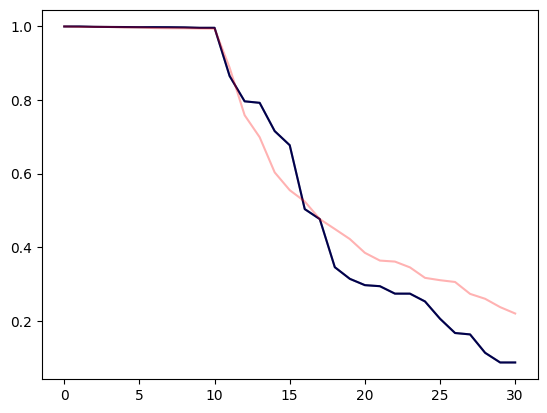

In [51]:
i = 0
plt.plot(surv[i], color = "black")
plt.plot(surv0[i], color = "blue", alpha = 0.3)
plt.plot(surv1[i], color = "red", alpha = 0.3)


Text(0.5, 1.0, "0-th individual's HTE")

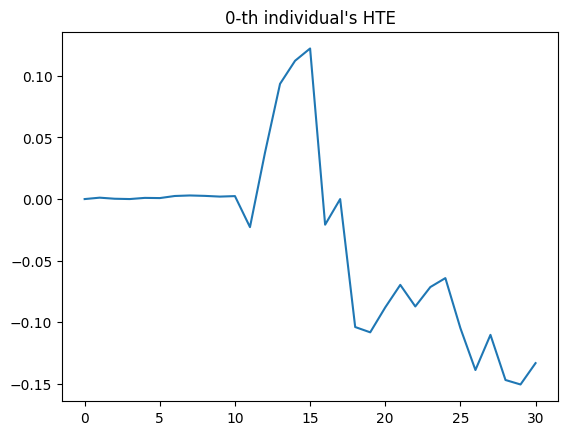

In [101]:
hte = surv0-surv1
plt.plot(hte[0])
plt.title("0-th individual's HTE")

Text(0.5, 1.0, "1028-th individual's HTE")

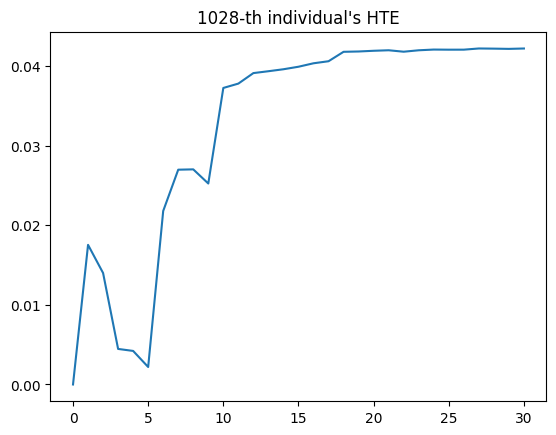

In [115]:
k = np.random.randint(0,5000)
plt.plot(hte[k])
plt.title(f"{k}-th individual's HTE")